# Feedback Prize - English Language Learning

### Evaluating language knowledge of ELL students from grades 8-12

## Problem Statement
The goal of this competition is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs). Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.

Your work will help ELLs receive more accurate feedback on their language development and expedite the grading cycle for teachers. These outcomes could enable ELLs to receive more appropriate learning tasks that will help them improve their English language proficiency.

## Importing the libraries

In [4]:
# General libraries
import numpy as np
import pandas as pd

# Visulaisation libraries.
import matplotlib.pyplot as plt
import seaborn as sns

# text libraries- NLP
import nltk
import gensim
import spacy

from tqdm import tqdm
tqdm.pandas()

from lightgbm import LGBMRegressor
from sklearn import model_selection
from sklearn import metrics

import string
from nltk.corpus import stopwords

## Uploading the files

In [5]:
from google.colab import files
upload = files.upload()


Saving text-test.csv to text-test.csv
Saving text-train.csv to text-train.csv


## Importing files.

In [6]:
train = pd.read_csv('text-train.csv')
test = pd.read_csv('text-test.csv')


In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Visualising the each columns

column 1: Cohension.

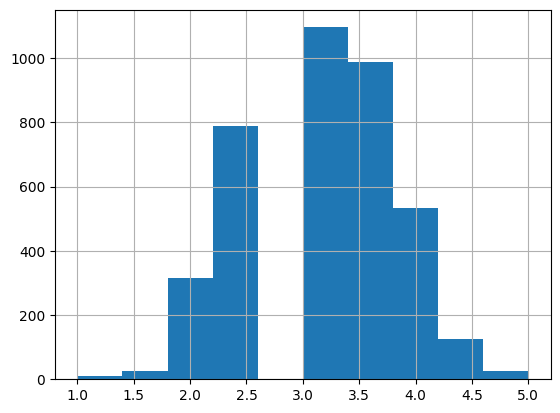

In [ ]:
train.cohesion.hist();

Column 2: syntax

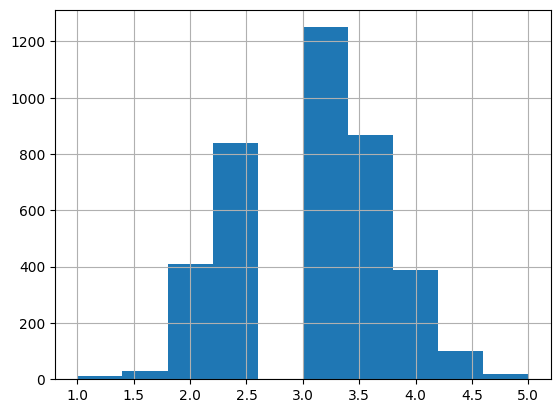

In [ ]:
train.syntax.hist();

Column 3: Vocabulary


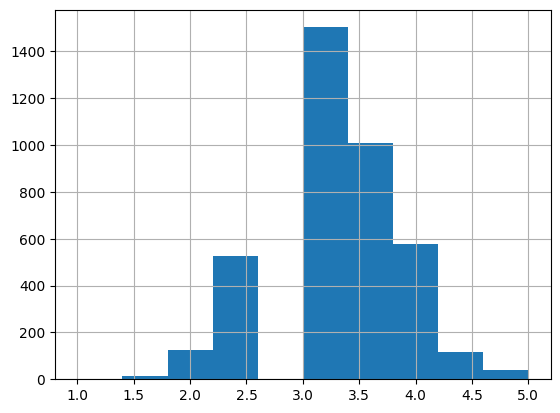

In [ ]:
train.vocabulary.hist();

## Staistical Summary 

In [9]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Getting the length of the text:

Average length of full_text.

Standard deviation of text.

Minimum length of the full_text

Maximum length of the full_text


In [10]:
# check length of content
def get_length_of_text(x):
    return len(x)

print(f'Average length: {train.full_text.apply(lambda x: get_length_of_text(x)).mean():0.2f}')
print(f'Std length: {train.full_text.apply(lambda x: get_length_of_text(x)).std():0.2f}')
print(f'Min length: {train.full_text.apply(lambda x: get_length_of_text(x)).min():0.2f}')
print(f'Max length: {train.full_text.apply(lambda x: get_length_of_text(x)).max():0.2f}')

Average length: 2334.52
Std length: 1033.41
Min length: 82.00
Max length: 6044.00


## Visualising the text length.

**Creating a histogram of the distribution of the lengths of the full_text**

The resulting histogram shows the frequency distribution of the lengths of the strings in the full_text column. It provides a visual representation of the distribution of the length of text data in the dataset. 



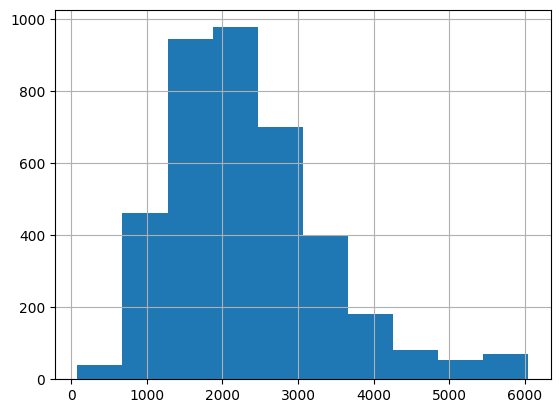

In [11]:
train.full_text.apply(lambda x: get_length_of_text(x)).hist();

### Need to visualise the text count.

1. Helps in understanding the nature of text data, 

2. Identifying any potential issues or anomalies, and 

3. Selecting appropriate pre-processing steps for machine learning or natural language processing tasks.

## Checking missing entries. 

In [12]:
train.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

## Correlation map



<ipython-input-9-d3e5b9b32147>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap=colormap);


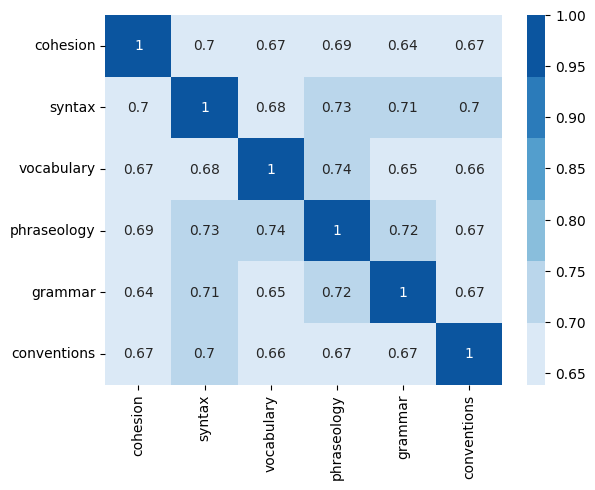

In [ ]:

colormap = sns.color_palette("Blues")
sns.heatmap(train.corr(), annot=True, cmap=colormap);

## Interpretation

The resulting heatmap shows the correlation between pairs of variables in the train dataset.

* Darker shades of blue indicating stronger positive correlation, 

* Lighter shades of blue indicating weaker positive correlation, and 

* The heatmap has the coorelation rate between 2 differnt varibles are below 0.8 

## Modeling
The idea here is to predict all variables.

Two approaches:

* Multioutput regression

* Single output regression x6

In [ ]:
train.head()

In [13]:
df = train.copy()
# we are going to iterate through each target variable
target_vars = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

## Feature Extraction - Vectorization.

vectorizer is used to transform new text data into a matrix of TF-IDF features using the transform() method. 

    The specific parameters used in the TfidfVectorizer object should be tuned for each individual application to obtain the best performance.



##### **Parameters in TfidfVectorizer:**

* smooth_idf=True: Enables the smoothing of the inverse document frequency (IDF) weights.

* sublinear_tf=True: Applies sublinear scaling to the term frequency (TF) weights.

* analyzer='char': Extracts features at the character level.

* ngram_range=(1, 3): Uses unigrams, bigrams, and trigrams as features.

* max_features=2000: Limits the maximum number of features to 2000. This can help reduce the size of the feature matrix and prevent overfitting.


In [14]:

# we need to extract the vectors from the text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(smooth_idf=True, 
                             sublinear_tf=True, 
                             analyzer='char', 
                             ngram_range=(1, 3),
                             max_features=2000,
                            ) # this should be tuned in the future
vectorizer.fit(raw_documents=train.full_text)                           

TfidfVectorizer(analyzer='char', max_features=2000, ngram_range=(1, 3),
                sublinear_tf=True)



## Extracting vectors:

**extract_vectors(x)** takes in a list of strings x and uses a vectorizer to transform the strings into vectors. 
The resulting vectors are converted to a NumPy array using the toarray() method and flattened into a 1D array using the flatten() method. The flattened arrays are returned as a list.



**syllable_count(word)** takes in a string word and counts the number of syllables in it.
  * converts the word to lowercase and initializes a counter to zero.
  * defines a string of vowels and checks if the first character of the word is a vowel.
  *  iterates over the rest of the characters in the word and increments the counter if a vowel follows a non-vowel.
  * If word ends in 'e', it decrements the counter by one. If the counter is zero, it sets it to one (to account for words with only one syllable). 




In [15]:
def extract_vectors(x):
    vecs = vectorizer.transform(x)
    return vecs.toarray().flatten()

# extract_vectors([train.iloc[0].full_text])
df['vecs'] = train.full_text.progress_apply(lambda x: extract_vectors([x]))

def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiou"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count


100%|██████████| 3911/3911 [00:18<00:00, 206.27it/s]




The flesch_kincaid_score(x) function takes in a string x and calculates the Flesch-Kincaid readability score of the text.

>**Formula to calculate Flesch-Kincaid readability score :**
>206.835 - 1.015 × (total words ÷ total sentences) - 84.6 × (total syllables ÷ total words)

1. Calculate total number of words in the text using the len() function on a split of the string by whitespace. 
2. Calculate the total number of sentences by splitting the text by periods (.) and using len() on the resulting list.
3. Calculate the total number of syllables in the text by calling the syllable_count() function on each word in the text using a list comprehension, and summing the resulting counts.
4. Calculate Flesch-Kincaid readability score

In [16]:
def flesch_kincaid_score(x):
    '206.835 - 1.015 × (total words ÷ total sentences) - 84.6 × (total syllables ÷ total words).'
    total_words = len(x.split())
    total_sentences = (len(x.split('.')))
    syllables = sum([syllable_count(w) for w in x.split()])
    return 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (syllables / total_words)

In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Importing the NLP library

In [19]:
import nltk

In [20]:
from nltk.corpus import stopwords
from string import punctuation


**Downloading the stopwords corpus to your machine.**

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Removing Stopwords.

**What is stopwords?**

Stopwords are words that have little semantic meaning and are often removed from text in NLP tasks. 
Example: "the", "and", "a", "an", "in", "on", etc.

**stopwords.words("english")** function call returns a list of common stop words in English.

**stop_nltk** creates a list of stop words used for text preprocessing, such as removing stop words or checking whether a word is a stop word.

In [22]:
stop_nltk=stopwords.words("english")

## Extracting the features.

**character count of each string**, used for text classification or sentiment analysis, where the length of a text can be an important indicator of its meaning or sentiment.

In [23]:
# extract features from text
from nltk.corpus import stopwords

df['char_count'] = df['full_text'].progress_apply(len)
df['char_count']

100%|██████████| 3911/3911 [00:00<00:00, 264076.80it/s]


0       1387
1       2635
2       1663
3       3973
4       1326
        ... 
3906     977
3907    2603
3908    1298
3909    2833
3910    3395
Name: char_count, Length: 3911, dtype: int64

##### Word count


In [24]:
df['word_count'] = df['full_text'].progress_apply(lambda x: len(x.split()))
df['word_count']

100%|██████████| 3911/3911 [00:00<00:00, 36348.40it/s]


0       261
1       533
2       320
3       728
4       234
       ... 
3906    179
3907    465
3908    257
3909    510
3910    638
Name: word_count, Length: 3911, dtype: int64

## Calculating word density.

**word_density** is created by dividing the char_count column by the sum of the word_count column and 1. 

We divide the total number of characters by the number of words, to get a rough estimate of the average length of each word,

we also take into account the fact that there may be single-word rows, in which  the denominator would be 0 if we didn't add 1.

In [25]:
df['word_density'] = df['char_count'] / (df['word_count'] + 1)
df['word_density']

0       5.293893
1       4.934457
2       5.180685
3       5.449931
4       5.642553
          ...   
3906    5.427778
3907    5.585837
3908    5.031008
3909    5.544031
3910    5.312989
Name: word_density, Length: 3911, dtype: float64

## Punctuation Count

In [26]:
df['punctuation_count'] = df['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['punctuation_count']

100%|██████████| 3911/3911 [00:00<00:00, 5597.18it/s]


0        21
1        21
2        36
3       108
4         3
       ... 
3906     13
3907     37
3908     21
3909     50
3910     46
Name: punctuation_count, Length: 3911, dtype: int64

## Stopword Count.

In [27]:
df['stopword_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_nltk]))
df['stopword_count']

100%|██████████| 3911/3911 [00:02<00:00, 1347.61it/s]


0       129
1       311
2       177
3       420
4       122
       ... 
3906     79
3907    243
3908    143
3909    276
3910    347
Name: stopword_count, Length: 3911, dtype: int64

## Flesch Kincaid Score

In [28]:
df['flesch_kincaid_score'] = df['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))
df['flesch_kincaid_score']

100%|██████████| 3911/3911 [00:05<00:00, 723.82it/s] 


0       86.250726
1       64.899624
2       81.143750
3       77.279299
4       40.803654
          ...    
3906    58.397742
3907    60.267894
3908    69.547969
3909    62.124902
3910    31.885837
Name: flesch_kincaid_score, Length: 3911, dtype: float64

## Upper case count

In [29]:
df['upper_case_word_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df['upper_case_word_count']

100%|██████████| 3911/3911 [00:00<00:00, 19687.17it/s]


0       1
1       2
2       9
3       9
4       0
       ..
3906    4
3907    2
3908    4
3909    0
3910    2
Name: upper_case_word_count, Length: 3911, dtype: int64

## Feature Engineering

In [30]:
eng_features = df.drop(['text_id', 'full_text', 'cohesion','syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'vecs'], axis=1).columns
eng_features

Index(['char_count', 'word_count', 'word_density', 'punctuation_count',
       'stopword_count', 'flesch_kincaid_score', 'upper_case_word_count'],
      dtype='object')



tqdm() function is used to provide a progress bar for the loop, which can be helpful when processing large datasets.

loops over each row of the DataFrame using the iterrows() method. For each row, it retrieves the vector vecs and the values for the selected English features eng_features 

In [32]:
feature_set = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    vecs = row['vecs']
    vals = row[eng_features].astype(float)
    features = np.hstack([vecs, vals]).flatten()
    feature_set.append(features)
X = np.array(feature_set)


100%|██████████| 3911/3911 [00:01<00:00, 2041.04it/s]


In [33]:
len(feature_set)

3911

**Creating Dataframe for the respective columns**

In [34]:
cohesion_train = df.cohesion.values
syntax_train = df.syntax.values
vocabulary_train = df.vocabulary.values
phraseology_train = df.phraseology.values
grammar_train = df.grammar.values
conventions_train = df.conventions.values

In [35]:
# values in the train dataframe.
print(cohesion_train)
print(syntax_train)
print(vocabulary_train)
print(phraseology_train)
print(grammar_train)
print(conventions_train)

[3.5 2.5 3.  ... 2.5 4.  3.5]
[3.5 2.5 3.5 ... 3.  4.5 2.5]
[3.  3.  3.  ... 3.  4.5 3.5]
[3. 2. 3. ... 3. 4. 3.]
[4.  2.  3.  ... 3.5 4.5 3. ]
[3.  2.5 2.5 ... 3.  4.5 3.5]


## Hyperparameter Tuning

hyperparameters seem to be related to tree-based models, such as XGBoost or LightGBM.


* cohesion: task related to measuring the cohesion between sentences or documents
* syntax: task related to syntactic analysis, such as parsing or part-of-speech tagging
* vocabulary: task related to measuring the complexity of the vocabulary used in a text
* phraseology: task related to identifying and analyzing idiomatic expressions or multi-word units
* grammar: task related to identifying and correcting grammar mistakes in a text
* conventions: task related to measuring adherence to conventions or standards, such as spelling or punctuation.

Parameters of Hyper tuning:
The hyperparameters 
*  number of estimators (i.e., the number of trees in the model), 
* regularization parameters (reg_alpha and reg_lambda), 
* subsampling parameters (subsample and colsample_bytree), 
* learning rate, 
* maximum depth of the trees, and 
* minimum number of samples required to split an internal node.

To avoid overfitting, the model uses above arguments. 

In [36]:
cohesion_best_params = {'n_estimators': 420, 'reg_alpha': 0.13919864437901744, 'reg_lambda': 0.5069801040693652, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'min_child_samples': 99}
syntax_best_params = {'n_estimators': 500, 'reg_alpha': 0.25908918503224804, 'reg_lambda': 0.004271708198460402, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 150, 'min_child_samples': 61}
vocabulary_best_params = {'n_estimators': 428, 'reg_alpha': 0.0010889416899550251, 'reg_lambda': 0.20016253704202466, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_samples': 19}
phraseology_best_params = {'n_estimators': 426, 'reg_alpha': 0.09286405380355575, 'reg_lambda': 0.011669618789040185, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'min_child_samples': 1}
grammar_best_params = {'n_estimators': 410, 'reg_alpha': 0.002402918599536554, 'reg_lambda': 0.011524180731876684, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_samples': 40}
conventions_best_params = {'n_estimators': 468, 'reg_alpha': 0.057858250513145686, 'reg_lambda': 4.601288604571916, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.05, 'max_depth': 150, 'min_child_samples': 34}

## Performance Container

In [37]:
training_performances_container = []
val_performances_container = []

In [38]:
training_performances_container

[]

In [39]:
val_performances_container

[]

## Cross Validation

The purpose of this code is to evaluate the performance of the different models on the given dataset using cross-validation. 

Defining a KFold cross-validation strategy with 2 splits and a random seed of 42. 

1. Splits the data into training and validation sets using the KFold strategy.
2. Fits a LightGBMRegressor model using the provided hyperparameters.
3. Predicts on the training and validation sets.
4. Calculates and stores the root mean squared error (RMSE) between the true labels and predicted values for both the training and validation sets.
5. Prints the RMSE scores for each fold and calculates the average scores across all folds.



In [ ]:
cv_strategy = model_selection.KFold(n_splits=2, shuffle=True, random_state=42)

performances = {}

for var in [("cohesion", cohesion_train, cohesion_best_params), ("syntax", syntax_train, syntax_best_params), ("vocabulary", vocabulary_train, vocabulary_best_params), 
            ("phraseology", phraseology_train, phraseology_best_params), ("grammar", grammar_train, grammar_best_params), ("conventions", conventions_train, conventions_best_params)]:
    print(f'Validating on {var[0]}')
    fold = 0
    train_scores = []
    val_scores = []
    
    for train_idx, val_idx in cv_strategy.split(X, var[1]):

        # train
        X_train = X[train_idx]
        y_train = var[1][train_idx]

        # validation
        X_val = X[val_idx]
        y_val = var[1][val_idx]

        # training
        model = LGBMRegressor(**var[2])
        model.fit(X_train, y_train)

        # predicting
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # storing scores
        train_score = np.sqrt(metrics.mean_squared_error(y_train, train_preds))
        val_score = np.sqrt(metrics.mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)

        print(f"Fold {fold} ==> Train accuracy: {train_score:0.4f} | Validation accuracy: {val_score:0.4f}")
        fold += 1

    training_performance = np.mean(train_scores)
    val_performance = np.mean(val_scores)
    
    training_performances_container.append(training_performance)
    val_performances_container.append(val_performance)
    print(f"END. Average training performance: {training_performance:0.4f} | Average validation performance: {val_performance:0.4f}")

Validating on cohesion
Fold 0 ==> Train accuracy: 0.2662 | Validation accuracy: 0.5474
Fold 1 ==> Train accuracy: 0.2631 | Validation accuracy: 0.5527
END. Average training performance: 0.2646 | Average validation performance: 0.5501
Validating on syntax
Fold 0 ==> Train accuracy: 0.1342 | Validation accuracy: 0.5270
Fold 1 ==> Train accuracy: 0.1360 | Validation accuracy: 0.5268
END. Average training performance: 0.1351 | Average validation performance: 0.5269
Validating on vocabulary
Fold 0 ==> Train accuracy: 0.0918 | Validation accuracy: 0.4714
Fold 1 ==> Train accuracy: 0.0922 | Validation accuracy: 0.4767
END. Average training performance: 0.0920 | Average validation performance: 0.4740
Validating on phraseology
Fold 0 ==> Train accuracy: 0.1006 | Validation accuracy: 0.5361
Fold 1 ==> Train accuracy: 0.0993 | Validation accuracy: 0.5491
END. Average training performance: 0.0999 | Average validation performance: 0.5426
Validating on grammar
Fold 0 ==> Train accuracy: 0.1323 | Val

## Model Building - LGBMRegressor

* LightGBM is a gradient boosting framework that uses tree-based learning algorithms.
* LightGBM is designed to be efficient and scalable for handling large-scale data, while providing accurate and fast predictions.

**How does it work? **

* It works by iteratively training decision trees on the residuals of the previous tree, trying to reduce the error in the predictions.

* At each iteration, the model tries to find the optimal split to minimize the loss function, which is the metric used to measure the error between the predicted and actual values. 
* LightGBM also employs a technique called "Gradient-based One-Side Sampling" (GOSS), which uses a large proportion of the samples with small gradients to accelerate the training process.

![image.png](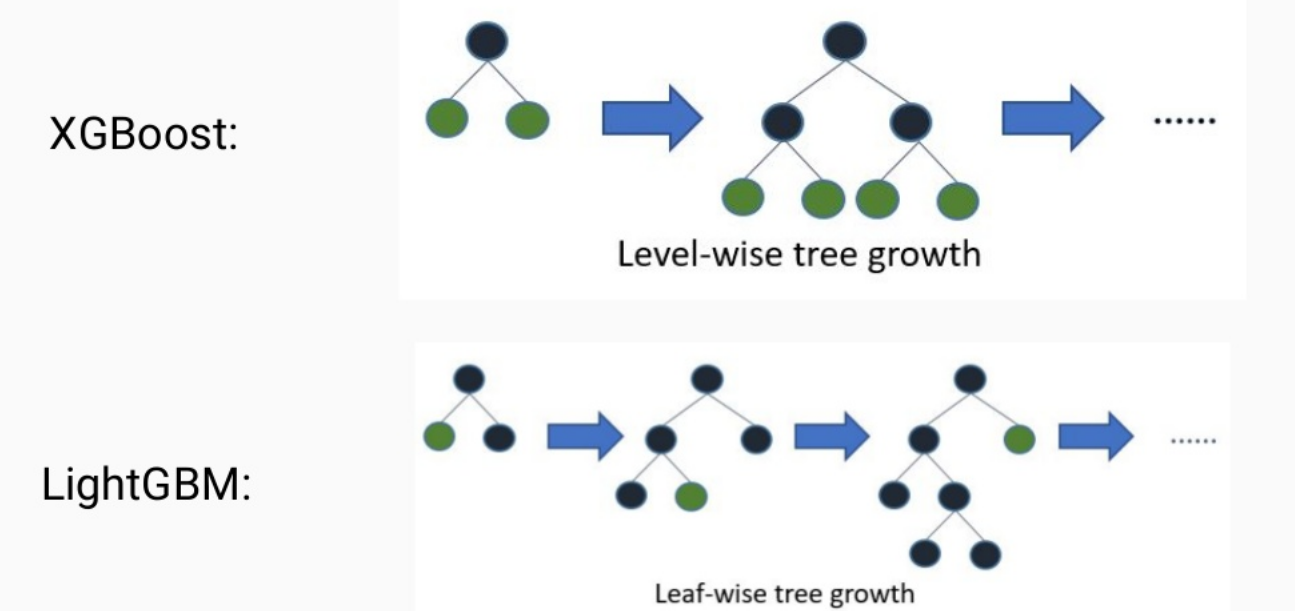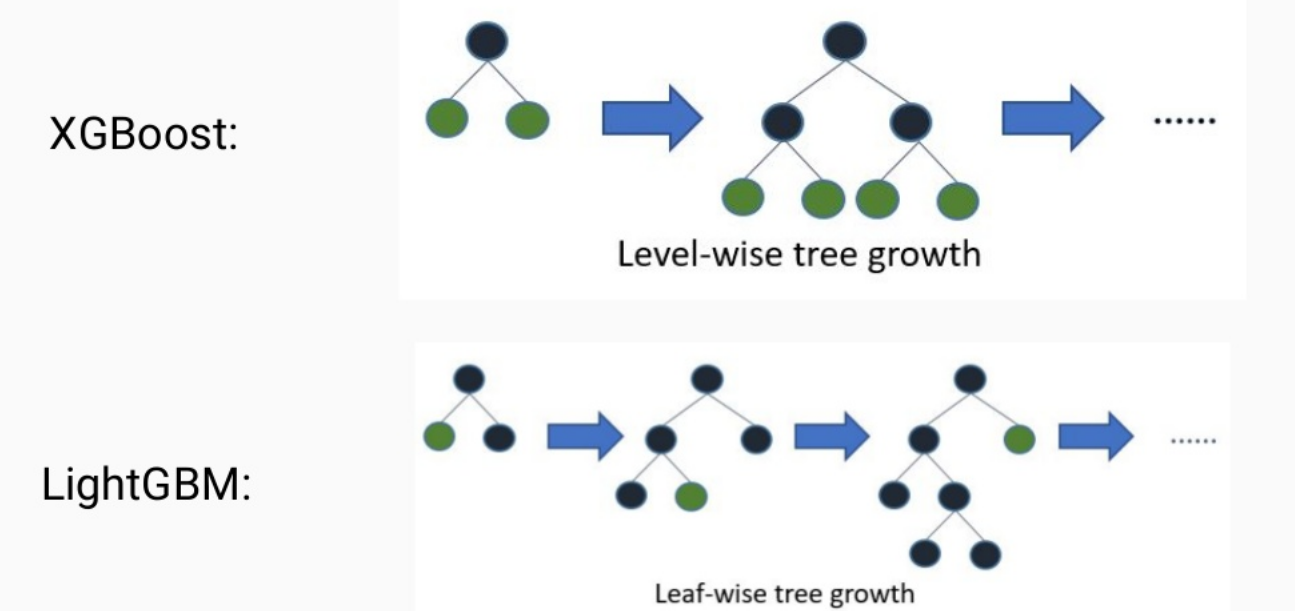)

In [40]:
cohesion_model = LGBMRegressor(**cohesion_best_params)
syntax_model = LGBMRegressor(**syntax_best_params)
vocabulary_model = LGBMRegressor(**vocabulary_best_params)
phraseology_model = LGBMRegressor(**phraseology_best_params)
grammar_model = LGBMRegressor(**grammar_best_params)
conventions_model = LGBMRegressor(**conventions_best_params)

## Fitting Model - Test Data

In [ ]:
cohesion_model.fit(X_val,y_val)
syntax_model.fit(X_val,y_val)
vocabulary_model.fit(X_val,y_val)
phraseology_model.fit(X_val,y_val)
grammar_model.fit(X_val,y_val)
conventions_model.fit(X_val,y_val)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=150,
              min_child_samples=34, n_estimators=468,
              reg_alpha=0.057858250513145686, reg_lambda=4.601288604571916,
              subsample=0.5)

## Test data.

Performing all the above steps on the test dataset.

In [7]:
test

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [41]:
_test = test.copy()
_test['vecs'] = _test.full_text.apply(lambda x: extract_vectors([x]))
_test['char_count'] = _test['full_text'].progress_apply(len)
_test['word_count'] = _test['full_text'].progress_apply(lambda x: len(x.split()))
_test['word_density'] = _test['char_count'] / (_test['word_count']+1)
_test['punctuation_count'] = _test['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
_test['title_word_count'] = _test['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
_test['upper_case_word_count'] = _test['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
_test['stopword_count'] = _test['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_nltk]))
_test['flesch_kincaid_score'] = _test['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))

100%|██████████| 3/3 [00:00<00:00, 817.55it/s]


## Preprocessing

In [ ]:
test_feature_set = []
for i, row in tqdm(_test.iterrows(), total=len(_test)):
    vecs = row['vecs']
    vals = row[eng_features].astype(float)
    features = np.hstack([vecs, vals]).flatten()
    test_feature_set.append(features)
X_test = np.array(test_feature_set)

100%|██████████| 3/3 [00:00<00:00, 653.15it/s]


## Predictiion

In [ ]:
cohesion_predictions = list(cohesion_model.predict(X_test))


In [ ]:
syntax_predictions = list(syntax_model.predict(X_test))
vocabulary_predictions = list(vocabulary_model.predict(X_test))
phraseology_predictions = list( phraseology_model.predict(X_test))
grammar_predictions = list(grammar_model.predict(X_test))
conventions_predictions = list(conventions_model.predict(X_test))

In [ ]:
predictions = {'cohesion':cohesion_predictions,
               'syntax':syntax_predictions,
               'vocabulary':vocabulary_predictions,
               'phraseology':phraseology_predictions,
               'grammar':grammar_predictions,
               'conventions':conventions_predictions}
            

predictions

{'cohesion': [3.0833204977510147, 3.003792829218167, 3.040952409317688],
 'syntax': [3.2156677343172277, 3.0068182862714576, 2.9877577753251034],
 'vocabulary': [3.1248684904586614, 2.8729842788848527, 3.0692713482060827],
 'phraseology': [3.152836022150749, 2.961872950307208, 3.072613771525595],
 'grammar': [2.9848643358031537, 2.9921940358051367, 2.998362261618408],
 'conventions': [3.0663173663157406, 3.0242001702165946, 3.001385591600952]}

## Result - submission

In [ ]:
submission = pd.DataFrame(predictions)
submission

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.083320,3.215668,3.124868,3.152836,2.984864,3.066317
1,3.003793,3.006818,2.872984,2.961873,2.992194,3.024200
2,3.040952,2.987758,3.069271,3.072614,2.998362,3.001386


In [ ]:
submission.to_csv("submission.csv", index=False)
